In [1]:
###To-Do:
#save weights for future use in HDF5: https://github.com/ajhalthor/Keras_LSTM_Text_Generator/blob/master/Text%20Generator%20(LSTM%20%2B%20Keras).ipynb
#also build a LSTM using multiple files similar to above

#Walk-forward validation:https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

#Pandas-profiling
#    Super awesome data EDA library
#Cufflinks & Plotly
#    Makes plotly even more amazing
#pprint
#change batch size

#normalize differently: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
#use data with categorical data to hot-encode

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import datetime as dt
import requests
from io import StringIO
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.core import Dense, Dropout, Activation
from tensorflow.python.keras.layers.recurrent import LSTM
from tensorflow.python.keras import backend as k
import pandas_datareader
from tensorflow.python.keras.callbacks import LambdaCallback
import lstm_c

#for printing in prediction plot
window = 10 #5 is too aggressive #10 is very conservative
epoch_num = 500#500 is too much #100 is not enough

Using TensorFlow backend.


In [3]:
def get_stock_data(stock_name, normalized=0):

    #load data
    start = dt.datetime(1995,1,1)
    end   = dt.date.today()
    df = pandas_datareader.data.DataReader(stock_name,'yahoo',start,end)
    df['Date'] = df.index
    df.index = pd.RangeIndex(len(df.index))
    df.index = range(len(df.index))
    df.drop(columns=['Low','Adj Close', 'Volume'], axis=1, inplace=True) 
    return df

In [4]:
stock_name = 'GOOG'
df = get_stock_data(stock_name,0)
df.tail()

,High,Open,Close,Date
3731,1099.180054,1086.280029,1092.500000,2019-06-17
3732,1116.390015,1109.689941,1103.599976,2019-06-18
3733,1107.000000,1105.599976,1102.329956,2019-06-19
3734,1120.119995,1119.989990,1111.420044,2019-06-20
3735,1124.109985,1109.239990,1121.880005,2019-06-21


In [5]:
##save data pulled in csv
today = datetime.date.today()
file_name = stock_name+'_stock_%s.csv' % today
df.to_csv(file_name)

In [6]:
df['High'] = df['High'] / 1000
df['Open'] = df['Open'] / 1000
df['Close'] = df['Close'] / 1000
df.tail(5)

,High,Open,Close,Date
3731,1.09918,1.08628,1.09250,2019-06-17
3732,1.11639,1.10969,1.10360,2019-06-18
3733,1.10700,1.10560,1.10233,2019-06-19
3734,1.12012,1.11999,1.11142,2019-06-20
3735,1.12411,1.10924,1.12188,2019-06-21


In [7]:
def load_data(stock, seq_len):
    t = stock.drop(columns=['Date'])
    amount_of_features = len(t.columns)
    datedf = stock.as_matrix()
    data = t.as_matrix() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    result_date = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
        result_date.append(datedf[index: index + sequence_length])

    result = np.array(result)
    result_date = np.array(result_date)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]
    test_dates = result_date[int(row):, -1][:,-1]
    check_data = result_date[int(row):, :-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test, test_dates, check_data, result]

In [8]:
def build_model(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16,kernel_initializer='random_uniform',activation='relu'))        
        model.add(Dense(1,kernel_initializer='random_uniform',activation='relu'))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

In [9]:
X_train, y_train, X_test, y_test, test_dates, check_data, result = load_data(df[::1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)
print("test_dates", test_dates.shape)

X_train (3352, 10, 3)
y_train (3352,)
X_test (373, 10, 3)
y_test (373,)
test_dates (373,)


In [10]:
model = build_model([3,window,1])


In [11]:
trained_epochs = []
tracker_cb = LambdaCallback(on_epoch_begin=lambda epoch, logs:print(epoch))

model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=epoch_num,
    validation_split=0.1,
    verbose=0,
    callbacks=[tracker_cb]
    )

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [12]:
#model.save('window_50.h5')
#model = load_model('my_model.h5')

In [13]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.00 MSE (0.01 RMSE)
Test Score: 0.00 MSE (0.03 RMSE)


In [14]:
# print(X_test[-1])
diff=[]
ratio=[]
pred = []
actual = []
p = model.predict(X_test) #Run on test set.
for u in range(len(y_test)):
    pr = p[u][0]
    pred.append(pr)
    actual.append(y_test[u])
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

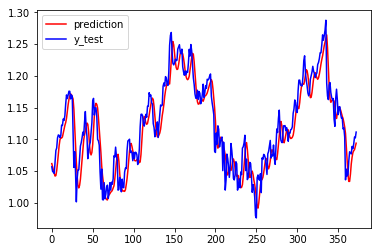

In [15]:
##Plotting predictions for test data
import matplotlib.pyplot as plt2


plt2.plot(p,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()

In [16]:
tmp = pd.DataFrame({'Date':test_dates, 'Prediction':pred, 'Actual':actual})
result_plot = tmp.set_index('Date')

In [17]:
import plotly as py
import cufflinks as cf
py.tools.set_credentials_file(username='ari0824', api_key='0iCd70k8eqKgJd60M64C')

result_plot.iplot(kind='scatter')

yo


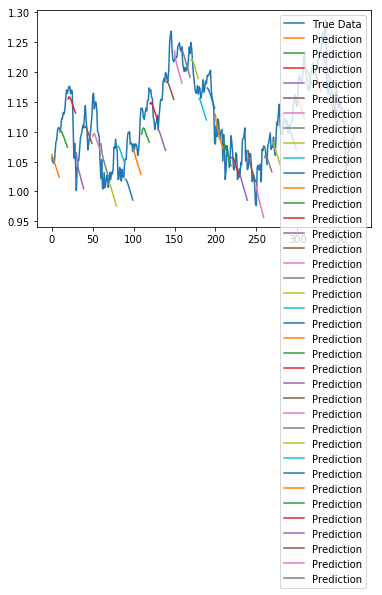

In [18]:
import lstm_c
pred_window = window
predictions = lstm_c.predict_sequences_multiple(model, X_test, pred_window, pred_window)
lstm_c.plot_results_multiple(predictions, y_test, pred_window)